In [ ]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *

import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split

from scipy.ndimage import gaussian_filter


C:\Users\ve59kedo\.conda\envs\HUNet\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



# In this part two list of paths are created. then they are removed if the annotated part of it is less than 5%


In [2]:
import os
import numpy as np
from PIL import Image
from natsort import natsorted
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.model_selection import train_test_split

data_dir = 'D:/Hamed/Forschungsproject/Hancock 2/Tiles_0.9_256_64_np'
tile_size1 = (256, 256)
tile_size2 = (256, 256, 1)
input_shape = (256, 256, 3)

x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('labelled.npy'):
        y.append(os.path.join(data_dir, filename))
    if filename.endswith('.npy'):
        x.append(os.path.join(data_dir, filename))

# List to store the paths of images with unique classes
full_set_y = []
full_set_x = []
counter = 0

# Create a copy of the original 'y' list
y_copy = y.copy()

# Loop through the dataset represented by 'y_copy'
unique_classes_encountered = set()
total_pixels = 256 * 256

for i in tqdm(range(len(y)), desc="Processing labels"):
    lbl_arr_path = y[i]

    # Check if the image contains at least one unique class from 1 to 12
    img = np.load(lbl_arr_path)
    unique_classes = np.unique(img)
    unique_classes_1_to_12 = [cls for cls in unique_classes if 1 <= cls <= 12]
    for cls in unique_classes_1_to_12:
        # Append the path to the full_set_y list
        img_clc = (img == cls)

        # Step 1: Count the number of ones using numpy
        num_ones = np.sum(img_clc == 1)

        # Step 2: Calculate percentage
        percentage_ones = (num_ones / total_pixels) * 100.0
        if percentage_ones >= 8.0:
            full_set_y.append(lbl_arr_path)
            break
        else:
            counter += 1

for mask_path in tqdm(full_set_y, desc="Processing images"):
    # Remove the '-labelled' from the mask path
    image_path = mask_path.replace('-labelled', '')
    full_set_x.append(image_path)

X_train, X_test, Y_train, Y_test = train_test_split(full_set_x, full_set_y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.18, random_state=42)

print("Dataset Sizes:")
print(f"killed {counter} unpure samples")
print(f"Training set: {len(X_train)} samples = {((len(X_train) / len(full_set_x)) * 100):.2f}%")
print(f"Validation set: {len(X_val)} samples = {((len(X_val) / len(full_set_x)) * 100):.2f}%")
print(f"Test set: {len(X_test)} samples = {((len(X_test) / len(full_set_x)) * 100):.2f}%")


Processing images: 100%|█████████████████████████████████████████████████████| 15417/15417 [00:00<00:00, 425678.77it/s]


Dataset Sizes:
killed 12049 unpure samples
Training set: 10745 samples = 69.70%
Validation set: 2359 samples = 15.30%
Test set: 2313 samples = 15.00%


# here we define the data generator for training. it generates batch of data, augments them, preprocesses them in different channels and also creates two new channels white bg and not annotated

In [3]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, list_labels, batch_size=2, shuffle=True, aug=True,num_class=4,remove_bg=0):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.class_names = [
            'Not_annotated',
            'Tumor_Verhornung',
            'All_Other',
            'White_BG'
        ]
        self.batch_size = batch_size
        self.list_labels = list_labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.num_class = num_class
        self.remove_bg = remove_bg
        self.unique = np.arange(0, 12, 1)
        if self.remove_bg:
            self.class_names = self.class_names[1:]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_label_paths = [self.list_labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_paths, list_label_paths)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_label_paths):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_label_paths)):
            # Store sample
            img_arr = np.load(sample_path)
            img_arr = np.resize(img_arr, (256,256,3))
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr /= 255.0 # normalize

            # Store label
            lbl_arr = np.load(label_path)
            lbl_arr = np.resize(lbl_arr, (256,256))
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], self.num_class), dtype=np.float32)

            for i, value in enumerate(self.unique):
                if value in [1]:  # Class 1: Tumor,
                    channels[:, :, 1] += (lbl_arr == value).astype(np.uint8)
                elif value == 0:  # Class 0: Not annotated
                    channels[:, :, 0] = (lbl_arr == value).astype(np.uint8)
                elif value in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:  # All other classes
                    channels[:, :, 2] += (lbl_arr == value).astype(np.uint8)
                    
                    

            # Apply Gaussian smoothing with a specified sigma (adjust sigma as needed)
            sigma = 8.0
            img_arr_smoothed = gaussian_filter(img_arr, sigma=sigma)

            # Threshold the image to make white pixels more visible
            threshold = 0.75
            img_arr_smoothed = np.mean(img_arr_smoothed,axis=2)
            img_arr_smoothed[img_arr_smoothed >= threshold] = 1.0
            img_arr_smoothed[img_arr_smoothed < threshold] = 0.0


            channels[:,:,-1] = img_arr_smoothed

            for i in range(0, self.num_class - 1):

                # Perform a bitwise AND operation to get the overlapping region
                overlap = (channels[:, :, i].astype(bool) & img_arr_smoothed.astype(bool)).astype(np.uint8)

                # Perform a bitwise XOR operation to delete the overlapping region from mask1
                channels[:, :, i] = (channels[:, :, i].astype(bool) ^ overlap).astype(np.uint8)

            lbl_arr = channels
            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1

            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else:
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images

    def viz(self, x_images, y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)
        for dx in range(batch_size):
            y_mask = y_images[dx]

            # Display original and transformed images side by side
            fig, axs = plt.subplots(1, len(self.class_names)+1, figsize=(20, 10))

            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')
            axs[0].axis('off')

            for i in range(0, len(self.class_names)):
                axs[i+1].imshow(y_mask[:, :, i])
                axs[i+1].axis('off')  # Remove axes
                axs[i+1].set_title(f'{self.class_names[i]}_{i}', fontsize=9)
            plt.show()

        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[dx])} and for masks {np.shape(y_images[dx])}')
        print(f'max value for images is {np.max(x_images[dx])} and for masks {np.max(y_images[dx])}')
        print(f'min value for images is {np.min(x_images[dx])} and for masks {np.min(y_images[dx])}')
        print(f'number of unique values in images is {len(np.unique(x_images[dx]))} and for masks {np.unique(y_images[dx])}')
    
    

# Here we would load 2000 data for our gif making task. 

In [ ]:
test = DataGenerator(X_test,Y_test,batch_size=2000,aug=1,remove_bg=0)
a,b = test.__getitem__(0)
#test.viz(a[11],b[11])


# We select an image we like to make gif out of it

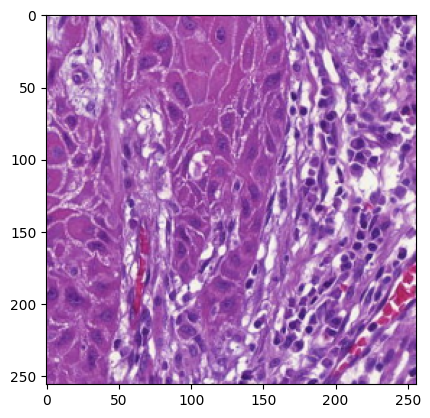

In [12]:
plt.imshow(a[18])

# And then we delet the image from the our 2000 dataset 

(1999, 1999)

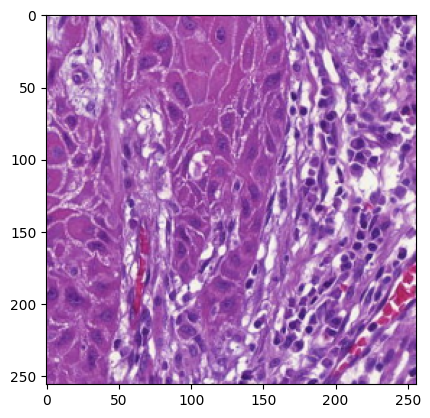

In [13]:
plt.imshow(a[18])
call_test1 = a[18]
call_test2 = b[18]
a = np.delete(a, 18, axis=0)
b = np.delete(b, 18, axis=0)
len(a),len(b)


In [66]:
np.shape(b[0][...,2])

(256, 256)

# So the GT and mask for out gif are plotted and saved 

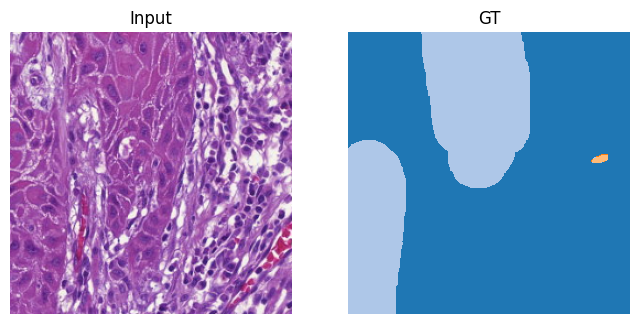

In [14]:
from matplotlib.colors import ListedColormap, BoundaryNorm

fig, ax = plt.subplots(1, 2, figsize=(8, 6))

ax[0].imshow(call_test1)

empty = np.zeros((256, 256))
# Loop through the images and plot them
ans = np.argmax(call_test2,axis=2)

# Create a custom discrete colormap with 13 colors
cmap = ListedColormap(plt.cm.tab20.colors[:4])
bounds = np.arange(0, 5) -0.5 # Set boundaries of color segments
norm = BoundaryNorm(bounds, cmap.N)
ax[1].axis('off')
ax[0].axis('off')
im = ax[1].imshow(ans, cmap=cmap, norm=norm)
ax[1].set_title('GT')
ax[0].set_title('Input')
plt.savefig('D:/Hamed/Forschungsproject/Hancock 2/GIF_expc4_MIT/GT2.png')



# Here we define the expriments(SGD + Wcat or Adam + Wcat) we want to try. 

In [ ]:
expriemtns = [[SGD,Wcat],[Adam,Wcat]]


# Just run the code for differnet number of epoch or different exprimets and gif would be generated out of it 

In [ ]:
from keras.optimizers import SGD
from keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.layers import Add
from segmentation_models.losses import *
from segmentation_models.metrics import *
from keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio
from segmentation_models import Unet
from tensorflow.keras.applications import EfficientNetB0


class_names = [
            'Not_Annotated',
            'Tumor',
            'Other',
            'White_BG']

def count_ones_per_channel(mask_list):
        num_channels = mask_list[0].shape[-1]
        result = [0] * num_channels

        for mask in mask_list:
            for channel in range(num_channels):
                result[channel] += np.sum(mask[..., channel])

        return np.array(result)
    
class_occurrences = count_ones_per_channel(b)

class_weights = np.sum(class_occurrences) / (4 * class_occurrences)

class_weights[0] = 0.0
    
# the classbakc class that we make gif with it later
class PredictionCallback(Callback):
    def __init__(self, model, input_image, output_path, num_classes):
        self.model = model
        self.input_image = input_image
        self.output_path = output_path
        self.num_classes = num_classes
        self.predictions = []

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(np.expand_dims(self.input_image, axis=0))[0]
        self.predictions.append(prediction)

SGD = SGD(lr=0.5, momentum=0.9)
Adam = Adam(learning_rate=0.1,beta_1=0.99)
AdamW = tfa.optimizers.AdamW(learning_rate=0.5,beta_1=0.99,weight_decay=0.004)

Wcat = CategoricalCELoss(class_weights=class_weights)


counter = 0 

for exp in expriemtns: 
    fil = 8 * (counter+1)
    
    fils = (fil*32,fil*16, fil*8, fil*4, fil*2)
    print(fils)
    model = Unet(classes=4, activation='softmax',input_shape=(256, 256, 3), decoder_filters=fils)

    metric = IOUScore()

    Wcat = CategoricalCELoss(class_weights=class_weights)

    IOUscore0 = IOUScore(class_indexes=0, name='IOU_Not_Annotated')
    IOUscore1 = IOUScore(class_indexes=1, name='IOU_Tumor')
    IOUscore2 = IOUScore(class_indexes=2, name='IOU_Other')
    IOUscore3 = IOUScore(class_indexes=3, name='IOU_White_BG')

    prediction_callback = PredictionCallback(model, call_test1, 'D:/Hamed/Forschungsproject/Hancock 2/GIF_expc4_MIT', 4)

    from keras.optimizers import SGD
    from keras.callbacks import ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam


    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)

    setup = fils

    # Update the loss in model compilation
    model.compile(optimizer=exp[0],
                  loss=exp[1],   # Updated loss function
                  metrics=[
                  IOUscore0,
                  IOUscore1,
                  IOUscore2,
                  IOUscore3,
                  ])


    history = model.fit(a,b,
                        epochs=2,
                        callbacks=[reduce_lr,prediction_callback]
                        )
    

    image_paths = []

    for idx in range(len(prediction_callback.predictions)):
        ans = np.argmax(prediction_callback.predictions[idx], axis=2)
        cmap = ListedColormap(plt.cm.tab20.colors[:4])

        # Set up the figure and axes
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.axis('off')

        # Plot the prediction
        im = ax.imshow(ans, cmap=cmap, vmin=-0.5, vmax=3.5)
        ax.set_title(f'Prediction - Epoch {idx + 1}')

        # Add colorbar next to the plot
        cbar = plt.colorbar(im, ax=ax, ticks=np.arange(0, 4), shrink=0.7)
        cbar.set_ticklabels(class_names)

        # Save the current plot as an image
        image_path = f'./trash/{setup}_plot_{idx}.png'
        plt.savefig(image_path, bbox_inches='tight')
        image_paths.append(image_path)
        plt.close()

    # Create GIF from saved images
    gif_path = f'D:/Hamed/Forschungsproject/Hancock 2/GIF_expc4_MIT/newmodel_{setup}.gif'
    images = [imageio.imread(image_path) for image_path in image_paths]
    imageio.mimsave(gif_path, images, duration=0.2)  # Adjust duration as needed
    counter = counter + 1


(256, 128, 64, 32, 16)
Epoch 1/2
11/63 [====>.........................] - ETA: 2:13 - loss: 0.1869 - IOU_Not_Annotated: 0.0561 - IOU_Tumor: 0.1085 - IOU_Other: 0.1229 - IOU_White_BG: 0.1619